# Code playground
This notebook is a small sandbox where half baked ideas can live. Code snippets that were developed but might be useful saterr can go here.

In [13]:
a = [(1,2),(3,4)]
b = [5,6]

b .index (6)

1

In [5]:
import re
re.split( " *" , "foo bar baz" ) 

['foo', 'bar', 'baz']

In [9]:
{'a':5}

{'a': 5}

In [11]:
from datetime import datetime
def super_print(filename):
    '''filename is the file where output will be written'''
    def wrap(func):
        '''func is the function you are "overriding", i.e. wrapping'''
        def wrapped_func(*args,**kwargs):
            '''*args and **kwargs are the arguments supplied 
            to the overridden function'''
            #use with statement to open, write to, and close the file safely
            with open(filename,'a') as outputfile:
                now = datetime.now()
                dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
                outputfile.write("[{}] ".format(dt_string))
                outputfile.write(" ".join(str(x) for x in args))
                outputfile.write("\n")
            #now original function executed with its arguments as normal
            return func(*args,**kwargs)
        return wrapped_func
    return wrap

print = super_print('logs-playground.txt')(print)

In [20]:
torch.tensor([1,4,3,6,2]).argsort()

tensor([0, 4, 2, 1, 3])

In [21]:
rand_transformer_model = nn.Transformer().to("cuda") # uses default hyperparameters
src = torch.rand((10, 32, 512)).to("cuda") # [src_seq_length, batch_size, embedding_size]
tgt = torch.rand((20, 32, 512)).to("cuda") # [tgt_seq_length, batch_size, embedding_size]
rand_transformer_model(src, tgt).shape # [tgt_seq_length, batch_size, embedding_size]

torch.Size([20, 32, 512])

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchtext
import tqdm
from torchnlp.metrics import get_moses_multi_bleu
from torchtext.data import Field, BucketIterator
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

import tensorflow as tf
import tensorflow_datasets as tfds
from tokenize import tokenize, untokenize, NUMBER, STRING, NAME, OP
from io import BytesIO

import matplotlib.pyplot as plt

import linecache
import sys
import os
import re
import random
import time
# import streamtologger
# streamtologger.redirect(target="./logs-playground.log")

ModuleNotFoundError: No module named 'matplotlib'

In [22]:
rand_transformer_model.decoder.layers[-1]

TransformerDecoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): Linear(in_features=512, out_features=512, bias=True)
  )
  (multihead_attn): MultiheadAttention(
    (out_proj): Linear(in_features=512, out_features=512, bias=True)
  )
  (linear1): Linear(in_features=512, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
)

In [31]:
q = torch.rand((20, 32, 512))
k = torch.rand((10, 32, 512))
v = torch.rand((10, 32, 512))
att = nn.MultiheadAttention(512, 2)
attn_output = att(q, k, v)
# attn_output

## Self-made beam search code
This code runs on paralelised batches and beams, it's fast, but doesn't have the appropriate stopping conditions.

In [ ]:
def beam_search_decode_batch_ids(encoder_input, beam_size=3, max_seq_length=50):
    batch_len = encoder_input.shape[1]
    sos_id = TGT_TEXT.vocab.stoi["<sos>"]
    decoder_input = torch.zeros((1, beam_size * batch_len), dtype=torch.long, device=device).fill_(sos_id)
    log_probs = torch.zeros((beam_size * batch_len,1))
    print("log_probs:", log_probs)
    vocab_size = len(TGT_TEXT.vocab.itos)
    
    encoder_input = encoder_input.view(-1,1).repeat(1,beam_size).view(-1,beam_size * batch_len) # this tiles the input to the beam size * batch size
    print("tiled input:", encoder_input)
    
    for i in range(max_seq_length):
        output = model(encoder_input, decoder_input)
        print(output.shape)
        last_pred = output[-1].softmax(1)
        print("last_pred shape:", last_pred.shape)
        log_predictions = last_pred.log()
        seq_log_probs = log_predictions + log_probs.repeat(1,vocab_size)
        print("seq_log_probs:", seq_log_probs)
        
        seq_log_probs_positions = seq_log_probs.view(batch_len,-1).argsort(1)[:,-beam_size:]
        print("seq_log_probs_positions:", seq_log_probs_positions)
        next_ids = seq_log_probs_positions.reshape(1, batch_len*beam_size) % vocab_size
        print("next_ids:", next_ids)
        log_probs = seq_log_probs.view(batch_len,-1).gather(1,seq_log_probs_positions).view(beam_size * batch_len,1)
        print("log_probs:",log_probs)
        
        for batch_idx in range(seq_log_probs_positions.shape[0]):
            for seq_choice_idx in range(seq_log_probs_positions.shape[1]):
                seq_choice = seq_log_probs_positions[batch_idx,seq_choice_idx] // vocab_size
                decoder_input[:,batch_idx*batch_len + seq_choice_idx] = decoder_input[:,batch_idx*batch_len + seq_choice]
        
        decoder_input = torch.cat((decoder_input, next_ids))
    return decoder_input
        
#         last_pred = output[-1].argsort(dim=1)[:,:beam_size]

sent1 = ["<sos>"] + SRC_TEXT.preprocess("create array") + ["<eos>"] + ["<pad>"]
sent2 = ["<sos>"] + SRC_TEXT.preprocess("if exists then") + ["<eos>"]
src_ids = SRC_TEXT.numericalize([sent1, sent2], device=device)
print("input ids:", src_ids)
beam_search_decode_batch_ids(src_ids, max_seq_length=5)

## Non batch single node beam search
This is the original beam search from online simply adapted to suit the transformerr architecture.

In [ ]:
class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
        '''
        :param hiddenstate:
        :param previousNode:
        :param wordId:
        :param logProb:
        :param length:
        '''
        self.h = hiddenstate
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.leng = length
        
    def __lt__(self, other):
        return True

    def eval(self, alpha=1.0):
        reward = 0
        beta = 4.0
        # Add here a function for shaping a reward

        return self.logp / float(self.leng - 1 + 1e-6) + alpha * reward

In [ ]:
def beam_decode(model, encoder_states):
    '''
    :param target_tensor: target indexes tensor of shape [B, T] where B is the batch size and T is the maximum length of the output sentence
    :param decoder_hidden: input tensor of shape [1, B, H] for start of the decoding
    :param encoder_outputs: if you are using attention mechanism you can pass encoder outputs, [T, B, H] where T is the maximum length of input sentence
    :return: decoded_batch
    '''

    beam_width = 10
    topk = 3  # how many sentence do you want to generate
    decoded_batch = []
    
    SOS_token = TGT_TEXT.vocab.stoi["<sos>"]
    EOS_token = TGT_TEXT.vocab.stoi["<eos>"]
    MAX_LENGTH = 7
    
    batch_size = encoder_states.shape[1]

    # decoding goes sentence by sentence
    for idx in range(batch_size):
        encoder_input = encoder_states[:, idx].view(-1,1)
        
        # Start with the start of the sentence token
        decoder_input = torch.LongTensor([[SOS_token]]).to(device)

        # Number of sentence to generate
        endnodes = []
        number_required = min((topk + 1), topk - len(endnodes))

        # starting node -  hidden vector, previous node, word id, logp, length
        node = BeamSearchNode(decoder_input, None, SOS_token, 0, 1)
        nodes = PriorityQueue()

        # start the queue
        nodes.put((-node.eval(), node))
        qsize = 1

        # start beam search
        while True:
            # give up when decoding takes too long
            if qsize > 400: break

            # fetch the best node
            score, n = nodes.get()
#             decoder_input = n.wordid
            decoder_input = n.h

            if n.wordid == EOS_token and n.prevNode != None:
                endnodes.append((score, n))
                # if we reached maximum # of sentences required
                if len(endnodes) >= number_required:
                    break
                else:
                    continue

            # decode for one step using decoder
#             decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)
#             print(encoder_input)
#             print(decoder_input)
            decoder_output = model(encoder_input, decoder_input)
            last_token_logits = decoder_output[-1]
            last_token_logs = last_token_logits.log_softmax(1)
            # PUT HERE REAL BEAM SEARCH OF TOP
            log_prob, indexes = torch.topk(last_token_logs, beam_width)
            nextnodes = []

            for new_k in range(beam_width):
                decoded_t = indexes[0][new_k]
                log_p = log_prob[0][new_k].item()
                decoder_input = torch.cat((decoder_input,decoded_t.view(1,-1)))
                node = BeamSearchNode(decoder_input, n, decoded_t.cpu().item(), n.logp + log_p, n.leng + 1)
                score = -node.eval()
                nextnodes.append((score, node))

            # put them into queue
            for i in range(len(nextnodes)):
                score, nn = nextnodes[i]
                nodes.put((score, nn))
                # increase qsize
            qsize += len(nextnodes) - 1

        # choose nbest paths, back trace them
        if len(endnodes) == 0:
            endnodes = [nodes.get() for _ in range(topk)]

        utterances = []
        for score, n in sorted(endnodes, key=operator.itemgetter(0)):
            utterance = []
            utterance.append(n.wordid)
            # back trace
            while n.prevNode != None:
                n = n.prevNode
                utterance.append(n.wordid)

            utterance = utterance[::-1]
            utterances.append(utterance)

        decoded_batch.append(utterances)

    return decoded_batch

sent1 = ["<sos>"] + SRC_TEXT.preprocess("call the options.get method with string 'CULL_FREQUENCY' and integer 3 as arguments, use the string 'cull_frequency' and previous result as the arguments for the call to the params.get method, substitute the result for cull_frequency.") + ["<eos>"] + ["<pad>"]
# sent2 = ["<sos>"] + SRC_TEXT.preprocess("if not,") + ["<eos>"]
src_ids = SRC_TEXT.numericalize([sent1], device=device)
# print("input ids:", src_ids)
outs = beam_decode(model, encoder_states=src_ids)

for b in outs:
    for sent in b:
        print([TGT_TEXT.vocab.itos[id] for id in sent])

## Adaptation of node based beam search to parallelise batches
This version comes from an already working version for a single batch. But there is a problem since when decodng different batches and passing them to the transformer, they all need to be the same length which doesn't work since there could be a node made in the past with a better probability score.
It doesn't look too obvious from what I see to speed it up while rretaining the theoretical benefits of being able to explore the full tree of options.

### The solution
You just need to add padding to the decoded sequences that are shorter and keep track of the position that you need to take the output token from. easy.

In [3]:
def beam_decode(model, encoder_states):
    '''
    :param target_tensor: target indexes tensor of shape [B, T] where B is the batch size and T is the maximum length of the output sentence
    :param decoder_hidden: input tensor of shape [1, B, H] for start of the decoding
    :param encoder_outputs: if you are using attention mechanism you can pass encoder outputs, [T, B, H] where T is the maximum length of input sentence
    :return: decoded_batch
    '''

    beam_width = 10
    topk = 3  # how many sentence do you want to generate
    decoded_batch = []
    
    batch_size = encoder_states.shape[1]
    
    SOS_token = TGT_TEXT.vocab.stoi["<sos>"]
    EOS_token = TGT_TEXT.vocab.stoi["<eos>"]
    MAX_LENGTH = 7

    # decoding goes all batches at the same time
    encoder_input = encoder_states

    # Start with the start of the sentence token
    decoder_input = torch.LongTensor([[SOS_token]]).to(device)

    # Number of sentence to generate
    batch_endnodes = [[] for i in range(batch_size)]
    number_required = topk

    # starting node -  hidden vector, previous node, word id, logp, length
    batch_node = [BeamSearchNode(decoder_input, None, SOS_token, 0, 1) for i in range(batch_size)]
    batch_nodes = [PriorityQueue() for i in range(batch_size)]

    # start the queue
    for nodes, node in zip(batch_nodes, batch_node):
        nodes.put((-node.eval(), node))
        
    batch_qsize = [1 for i in range(batch_size)]

    # start beam search
    while True:
        # give up when decoding takes too long for the first batch, placeholder for now
        print(batch_qsize)
        if batch_qsize[0] > 200: break

        # fetch the best node
        best_nodes = [nodes.get() for nodes in batch_nodes]
#         score, n = nodes.get()
#             decoder_input = n.wordid
#         decoder_input = n.h
        
        finished_nodes = [True if n.wordid == EOS_token and n.prevNode != None else False for (score, n) in best_nodes]
        print(finished_nodes)
        
        working_nodes = []
        working_node_id = 0
        working_nodes_idx = []
        for endnodes, (score, n) in zip(batch_endnodes, best_nodes):
            if n.wordid == EOS_token and n.prevNode != None and len(endnodes) < number_required:
                endnodes.append((score, n))
            else:
                working_nodes.append((score, n))
                working_nodes_idx.append(working_node_id)
            working_node_id += 1
        
        if all([len(endnodes) >= number_required for endnodes in batch_endnodes]):
            break
        
        num_working_nodes = len(working_nodes)
        print(working_nodes)
        
        step_encoder_input = encoder_input[:,:num_working_nodes].view(-1,num_working_nodes)
        print("[n.h for (score, n) in working_nodes] shape:", [n.h.shape for (score, n) in working_nodes])
        step_decoder_input = torch.cat([n.h for (score, n) in working_nodes],dim=1)
#         print("step_encoder_input shape:", step_encoder_input.shape)
        step_decoder_output = model(step_encoder_input, step_decoder_input)
        step_token_logits = step_decoder_output[-1]
        
        print(step_token_logits)

        # PUT HERE REAL BEAM SEARCH OF TOP
        log_prob, indexes = torch.topk(step_token_logits, beam_width)
        print(log_prob.shape)
        
    
        nextnodes = []
        
        for batch_id in working_nodes_idx:
            for new_k in range(beam_width):
                decoded_t = indexes[batch_id][new_k]
                log_p = log_prob[batch_id][new_k].item()
#                 print("decoder_input shape", step_decoder_input.shape)
#                 print("step_decoder_input shape:", step_decoder_input[:,batch_id].view(-1,1).shape)
#                 print("decoded_t shape:", decoded_t.view(1,-1).shape)
                decoder_input = torch.cat((step_decoder_input[:,batch_id].view(-1,1),decoded_t.view(1,-1)), dim=0)
#                 print("decoder_input shape:", decoder_input.shape)
                node = BeamSearchNode(decoder_input, working_nodes[batch_id], decoded_t.cpu().item(), n.logp + log_p, n.leng + 1)
                score = -node.eval()
                batch_nodes[batch_id].put((score, node))
                batch_qsize[batch_id] += 1
        
        # put them into queue
#         for i in range(len(nextnodes)):
#             score, nn = nextnodes[i]
#             nodes.put((score, nn))
#             # increase qsize
#         qsize += len(nextnodes) - 1

    # choose nbest paths, back trace them
    if len(endnodes) == 0:
        endnodes = [nodes.get() for _ in range(topk)]

    utterances = []
    for score, n in sorted(endnodes, key=operator.itemgetter(0)):
        utterance = []
        utterance.append(n.wordid)
        # back trace
        while n.prevNode != None:
            n = n.prevNode
            utterance.append(n.wordid)

        utterance = utterance[::-1]
        utterances.append(utterance)

    decoded_batch.append(utterances)

    return decoded_batch

sent1 = ["<sos>"] + SRC_TEXT.preprocess('try,') + ["<eos>"] + ["<pad>"]
sent2 = ["<sos>"] + SRC_TEXT.preprocess("if not,") + ["<eos>"]
src_ids = SRC_TEXT.numericalize([sent1, sent2], device=device)
# print("input ids:", src_ids)
[len(x) for x in beam_decode(model, encoder_states=src_ids)[0]]

NameError: name 'SRC_TEXT' is not defined

## Debug dataset

In [ ]:
# debug_data = [
#     ("my favourite foods are banana and toast","would you like banana and toast ?"),
#     ("my favourite foods are eggs and bacon and beans","would you like eggs and bacon and beans ?"),
#     ("my favourite food is chocolate","would you like chocolate ?"),
#     ("my favourite food is avocado","would you like avocado ?")
# ]

# other_data = [
#     ("what age is she ?", "she is 8 years old"),
#     ("what age is he ?", "he is 4 years old"),
#     ("how old are you ?", "i am 22 years old"),
#     ("how old am i ?", "you are 28 years old")
# ]

# SRC_TEXT = Field(sequential=True, tokenize=string_split, init_token='<sos>',eos_token='<eos>')
# TGT_TEXT = Field(sequential=True, tokenize=string_split, init_token='<sos>',eos_token='<eos>')

# train_dataset = val_dataset = samples_to_dataset(other_data, SRC_TEXT, TGT_TEXT)

# # train_dataset, val_dataset = dataset.split([0.7,0.3])

## Adding Noise to the decoding process during training

In [85]:
noise_e = 0.4
noise_mask = (torch.rand(10,10) > noise_e).float()

mask = (torch.triu(torch.ones(10,10))).transpose(0, 1)
mask = torch.mul(mask, noise_mask)
v = (torch.sum(mask, dim=-1) == 0).float()

fix_mask = torch.zeros(10,10)
fix_mask[:,0] = 1.0
v = v.repeat(10, 1).transpose(0,1)
fix_mask = torch.mul(fix_mask,v)

print(fix_mask)
mask += fix_mask


mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
mask

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., -inf, -inf, -inf, 0., -inf, -inf, -inf, -inf, -inf],
        [-inf, 0., 0., -inf, -inf, 0., -inf, -inf, -inf, -inf],
        [0., -inf, 0., 0., -inf, -inf, 0., -inf, -inf, -inf],
        [-inf, 0., 0., -inf, 0., 0., 0., 0., -inf, -inf],
        [-inf, 0., 0., 0., 0., -inf, 0., -inf, 0., -inf],
        [0., -inf, 0., 0., -inf, 0., -inf, 0., -inf, -inf]])

## Pytorch target masking transformer bug
There is a bug in the implementation of the transformer attention mask during decoding. It being produced the other way round, paying attention to parts of the sentence that appear at the end. It is a simple to fix at removing ==1

In [2]:
model = nn.Transformer()
model.generate_square_subsequent_mask(4)

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [82]:
sz = 4
mask = (torch.triu(torch.ones(sz, sz))==1).transpose(0, 1).float()
print(mask)
mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
mask

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])


tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [74]:
a = (torch.ones(10)==1)
a.masked_fill(a == 1, float('-inf'))

tensor([True, True, True, True, True, True, True, True, True, True])

In [146]:
from queue import PriorityQueue
a = PriorityQueue()
a.put(torch.tensor(1))
a.put(torch.tensor(-2))
a.get()

tensor(-2)

In [128]:
a = torch.tensor([[1],[2],[3]])
b = torch.tensor([[3],[4]])
rough_input = [a,b]
m = max([t.shape[0] for t in rough_input])
print(m)
z = torch.zeros((m,2)).fill_(7)
for i in range(2):
    length = rough_input[i].shape[0]
    z[:length,i] = rough_input[i].view(-1)
print(z)

3
tensor([[1., 3.],
        [2., 4.],
        [3., 7.]])


In [140]:
outputs = torch.tensor([[[1],[5]],[[2],[6]],[[3],[7]],[[4],[8]]]).transpose(0,1)
p_mask = [2,3]

for l in outputs[]:
    print(l)

tensor([[1],
        [2],
        [3],
        [4]])
tensor([[5],
        [6],
        [7],
        [8]])


In [10]:
a = torch.tensor([1.,2,3,4, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).softmax(0)
a

tensor([0.0259, 0.0705, 0.1917, 0.5210, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095,
        0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095,
        0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095])

In [13]:
atts = torch.rand(2,4,3).transpose(0,1) # [output_seq_length, batch_size, input_seq_length]
print("atts:", atts)
print("atts.shape:", atts.shape)

# atts = atts * torch.tensor([[[0.1],[1]],[[10],[100]],[[1000],[10000]],[[100000],[1000000]]])
print("atts:", atts)

# src = torch.randint(0, 10, (3,2))
src = torch.tensor([[1,2],
                    [3,4],
                    [5,6]])
print("src:", src)
src = src.transpose(0,1)
print("src.T:", src)
src = src.unsqueeze(0)
print("src.unsqueeze:", src)
src = torch.repeat_interleave(src, 4, dim=0)
print("src.inter:", src)
print("src.inter.shape:", src.shape)

out_dist = torch.zeros(4, 2, 10).scatter_add_(2,src,atts)
print(out_dist)

atts: tensor([[[0.0248, 0.1017, 0.7406],
         [0.8730, 0.7230, 0.6886]],

        [[0.0148, 0.6740, 0.0523],
         [0.4018, 0.8585, 0.9774]],

        [[0.9876, 0.9629, 0.4758],
         [0.0139, 0.4103, 0.1767]],

        [[0.9024, 0.3109, 0.5361],
         [0.5023, 0.6643, 0.6590]]])
atts.shape: torch.Size([4, 2, 3])
atts: tensor([[[0.0248, 0.1017, 0.7406],
         [0.8730, 0.7230, 0.6886]],

        [[0.0148, 0.6740, 0.0523],
         [0.4018, 0.8585, 0.9774]],

        [[0.9876, 0.9629, 0.4758],
         [0.0139, 0.4103, 0.1767]],

        [[0.9024, 0.3109, 0.5361],
         [0.5023, 0.6643, 0.6590]]])
src: tensor([[1, 2],
        [3, 4],
        [5, 6]])
src.T: tensor([[1, 3, 5],
        [2, 4, 6]])
src.unsqueeze: tensor([[[1, 3, 5],
         [2, 4, 6]]])
src.inter: tensor([[[1, 3, 5],
         [2, 4, 6]],

        [[1, 3, 5],
         [2, 4, 6]],

        [[1, 3, 5],
         [2, 4, 6]],

        [[1, 3, 5],
         [2, 4, 6]]])
src.inter.shape: torch.Size([4, 2, 3])
ten

# Python AST doodles

In [2]:
import ast
import astor

import execnet
import inspect

In [5]:
def call_python_version(Version, Module, Function, ArgumentList):
    gw      = execnet.makegateway("popen//python=python%s" % Version)
    channel = gw.remote_exec("""
        from %s import %s as the_function
        channel.send(the_function(*channel.receive()))
    """ % (Module, Function))
    channel.send(ArgumentList)
    return channel.receive()

In [6]:
def foo(*bar):
    print(bar)

In [7]:
func_source = inspect.getsource(foo)
print(func_source)

def foo(*bar):
    print(bar)



In [8]:
foo("this", "is")

('this', 'is')


In [9]:
def run_as_python2(code_string):
    gw = execnet.makegateway("popen//python=python2")
    channel = gw.remote_exec(f"""
        channel.send("the_function(*channel.receive())")""")

In [10]:
result = call_python_version("3", "python2_code", "my_function",  
                             ["Mr", "Bear"]) 
print(result) 
result = call_python_version("2", "python2_code", "string_py2_ast",  
                             ["print 'foo' "]) 
print(result)

Hello Mr Bear!


RemoteError: Traceback (most recent call last):
  File "<string>", line 1084, in executetask
  File "<string>", line 1, in do_exec
  File "<remote exec>", line 3, in <module>
  File "<string>", line 729, in send
  File "<string>", line 1371, in dumps_internal
  File "<string>", line 1389, in save
  File "<string>", line 1405, in _save
DumpError: can't serialize <class '_ast.Module'>


In [78]:
eval("Store")

_ast.Store

In [65]:
from collections.abc import Iterable

def is_primitive(obj):
    return any([isinstance(obj, str),isinstance(obj, int),isinstance(obj, float)])

def ast_to_production_rules(tree):
    
    fields = tree._fields
    name = type(tree).__name__
    print(name, end =" ")
    
    for field in fields:
        field_obj = getattr(tree, field)
        
        if field_obj==None:
            continue
            
        elif is_primitive(field_obj):
            print(field, end=" ")
            print(field_obj, end=" ")
            
        elif isinstance(field_obj, Iterable):
            print(field, end=" ")
            for elem in field_obj:
                ast_to_production_rules(elem)
            print("<end_list>", end=" ")
        else:
            print(field, end=" ")
            ast_to_production_rules(field_obj)
        
        


In [143]:
ast_to_production_rules(tree)

Module body Assign targets Name id a ctx Store <end_list> value Num n 0.4 <end_list> 

In [125]:
a='this \' is'
a

"this ' is"

In [16]:
code_string = "parser . add_argument ( 'app_label' ,  help = 'App label of the application containing the migration.' )"
tree = ast.parse(code_string)
# tree = ast.parse("a='foo'")
print(ast.dump(tree))
print()
print(astor.to_source(tree))

Module(body=[Expr(value=Call(func=Attribute(value=Name(id='parser', ctx=Load()), attr='add_argument', ctx=Load()), args=[Str(s='app_label')], keywords=[keyword(arg='help', value=Str(s='App label of the application containing the migration.'))]))])

parser.add_argument('app_label', help=
    'App label of the application containing the migration.')



In [17]:
def to_num(s):
    try:
        return int(s)
    except ValueError:
        return float(s)

In [19]:
import importlib

def new_dump_to_ast(dump_string):
    first_paren = dump_string.index("(")
    node_string = dump_string[:first_paren]
#     print(1, "creating node type:", node_string)
    module = importlib.import_module("ast")
    class_ = getattr(module, node_string)
    node = class_()
    inner_paren = dump_string[first_paren+1:-1]
    
    # handle variable length attributes
    while len(inner_paren) > 0:
        print(2, "Attr string so far:", inner_paren)
        equal_idx = inner_paren.index("=")
        attr_string = inner_paren[:equal_idx]
        print(3, "attribute name:", attr_string)
        
        # 5 cases: None, num, string, list, node
        # first check if None
#         print(4, "checking None:", inner_paren[equal_idx+1:equal_idx+5])
#         print(5, "checking number:", inner_paren[equal_idx+1], inner_paren[equal_idx+1].isnumeric())
        print(6, "checking Quote or DQuote:", inner_paren[equal_idx+1] == "'" or inner_paren[equal_idx+1] == '"')
        
        if inner_paren[equal_idx+1:equal_idx+5] == "None":
            setattr(node, attr_string, None)
            inner_paren = inner_paren[equal_idx + 7:]
        
        elif inner_paren[equal_idx+1:equal_idx+5] == "True":
            setattr(node, attr_string, True)
            inner_paren = inner_paren[equal_idx + 7:]
            
        elif inner_paren[equal_idx+1:equal_idx+6] == "False":
            setattr(node, attr_string, False)
            inner_paren = inner_paren[equal_idx + 8:]
            
        # check if first character is a number
        elif inner_paren[equal_idx+1].isnumeric():
            number_finder = re.compile("([0-9]+(.?[0-9]*))( *([a-zA-Z]+))*")
            groups = number_finder.match(inner_paren[equal_idx+1:]).groups()
#             print(6, "Number groups identified:", groups)
            num = to_num(groups[0])
#             print(7, "Number:", num)
            setattr(node, attr_string, num)
            inner_paren = inner_paren[equal_idx + len(groups[0])+2:]
        
        # check if first Character is quote or double quote to see if it's a string
        elif inner_paren[equal_idx+1] == "'" or inner_paren[equal_idx+1] == '"':
            string_matcher = re.compile("['\"](.*?)['\"]")
            string = string_matcher.findall(inner_paren[equal_idx:])[0]
            setattr(node, attr_string, string)
            inner_paren = inner_paren[equal_idx + len(string)+5:]
        
        # deal with list
        elif inner_paren[equal_idx+1] == "[":
            list_last_square = get_square_index(inner_paren, equal_idx+1)
            list_string = inner_paren[equal_idx+2:list_last_square]
            
            elem_list = []
            while len(list_string) > 0:
#                 print(8, "List string so far:", list_string)
                value_first_paren = list_string.index("(")
                value_last_paren = get_paren_index(list_string, value_first_paren)
                list_value_ast = new_dump_to_ast(list_string[:value_last_paren+1])
                elem_list.append(list_value_ast)
                list_string = list_string[value_last_paren+3:]
            setattr(node, attr_string, elem_list)
            inner_paren = inner_paren[list_last_square+3:]
        
        # deal with node
        else:
            value_first_paren = inner_paren.index("(")        
            value_last_paren = get_paren_index(inner_paren, value_first_paren)
#             print(9,"handling Node for: ",inner_paren[equal_idx+1:value_last_paren+1])
            value_ast = new_dump_to_ast(inner_paren[equal_idx+1:value_last_paren+1])
#             print(10, f"obtained AST for{attr_string}:", value_ast)
            setattr(node, attr_string, value_ast)
            inner_paren = inner_paren[value_last_paren+3:]
    
    
    return node

print(ast.dump(tree))
print()
t = tree
print("Reduced tree:", ast.dump(t))
new_ast = new_dump_to_ast(ast.dump(t))

print()
print(ast.dump(new_ast))

print()
print(f"OG String    : {code_string}")
print(f"Code from AST: {astor.to_source(t)}")
print(f"Rebuilt AST  : {astor.to_source(new_ast)}")

Module(body=[Expr(value=Call(func=Attribute(value=Name(id='parser', ctx=Load()), attr='add_argument', ctx=Load()), args=[Str(s='app_label')], keywords=[keyword(arg='help', value=Str(s='App label of the application containing the migration.'))]))])

Reduced tree: Module(body=[Expr(value=Call(func=Attribute(value=Name(id='parser', ctx=Load()), attr='add_argument', ctx=Load()), args=[Str(s='app_label')], keywords=[keyword(arg='help', value=Str(s='App label of the application containing the migration.'))]))])
2 Attr string so far: body=[Expr(value=Call(func=Attribute(value=Name(id='parser', ctx=Load()), attr='add_argument', ctx=Load()), args=[Str(s='app_label')], keywords=[keyword(arg='help', value=Str(s='App label of the application containing the migration.'))]))]
3 attribute name: body
6 checking Quote or DQuote: False
2 Attr string so far: value=Call(func=Attribute(value=Name(id='parser', ctx=Load()), attr='add_argument', ctx=Load()), args=[Str(s='app_label')], keywords=[keyword(arg='h

In [332]:
import importlib
module = importlib.import_module("ast")
class_ = getattr(module, "Module")
instance = class_()
type(instance)

_ast.Module

In [ ]:
with open("datasets/all.code", "r") as f:
    count = 0
    all_lines = 0
    for line in f.readlines():
        all_lines+=1
        try:
            can_code = canonicalize_code(line[:-1])
            code_ast = ast.parse(can_code)
            new_ast = new_dump_to_ast(ast.dump(code_ast))
            can_code_ast = astor.to_source(new_ast)

            de_can_code_ast = de_canonicalize_code(can_code_ast, code)
            de_can_code_ast = re.sub(r'\n', '', de_can_code_ast)
            count += 1
        except:
            print(line[:-1])
            pass
print(f"{count}/{all_lines} = {count*100/all_lines:.2f}%")

In [6]:
p_elif = re.compile(r'^elif\s?')
p_else = re.compile(r'^else\s?')
p_try = re.compile(r'^try\s?')
p_except = re.compile(r'^except\s?')
p_finally = re.compile(r'^finally\s?')
p_decorator = re.compile(r'^@.*')


def canonicalize_code(code):
    code = code.strip()
    if p_elif.match(code):
        code = 'if True: pass\n' + code

    if p_else.match(code):
        code = 'if True: pass\n' + code

    if p_try.match(code):
        code = code + 'pass\nexcept: pass'
    elif p_except.match(code):
        code = 'try: pass\n' + code
    elif p_finally.match(code):
        code = 'try: pass\n' + code

    if p_decorator.match(code):
        code = code + '\ndef dummy(): pass'

    if code[-1] == ':':
        code = code + 'pass'

    return code


def de_canonicalize_code(code, ref_raw_code):
    ref_raw_code = ref_raw_code.strip()
    if code.endswith('def dummy():\n    pass'):
        code = code.replace('def dummy():\n    pass', '').strip()

    if p_elif.match(ref_raw_code):
        # remove leading if true
        code = code.replace('if True:\n    pass', '').strip()
    elif p_else.match(ref_raw_code):
        # remove leading if true
        code = code.replace('if True:\n    pass', '').strip()

    # try/catch/except stuff
    if p_try.match(ref_raw_code):
        code = code.replace('except:\n    pass', '').strip()
    elif p_except.match(ref_raw_code):
        code = code.replace('try:\n    pass', '').strip()
    elif p_finally.match(ref_raw_code):
        code = code.replace('try:\n    pass', '').strip()

    # remove ending pass
    if code.endswith(':\n    pass\n') or code.endswith(':\n    pass'):
        code = code.replace('\n    pass', '').strip()

    return code

code = linecache.getline("datasets/all.code", 18345).rstrip()
print(code)
# code = "eol_message = message . replace ( str ( '\r\n' ) , str ( '\n' ) ) . replace ( str ( '\r' ) , str ( '\n' ) )"
can_code = canonicalize_code(code)
print(can_code)
code_ast = ast.parse(can_code)
new_ast = new_dump_to_ast(ast.dump(code_ast))
can_code_ast = astor.to_source(new_ast)
print(can_code_ast)
de_can_code_ast = de_canonicalize_code(can_code_ast, code)
print(de_can_code_ast)
de_can_code_ast = re.sub(r'\n', '', de_can_code_ast)
print(de_can_code_ast)

  else :
if True: pass
else :pass
2 Attr string so far: body=[If(test=NameConstant(value=True), body=[Pass()], orelse=[Pass()])]
3 attribute name: body
6 checking Quote or DQuote: False


NameError: name 'get_square_index' is not defined

In [478]:
get_square_index("[()th[]is]", 0)

9

In [493]:
print(re.sub(r'\n', '', can_code_ast))

eol_message = message.replace(str('\r\n'), str('\n')).replace(str('\r'),    str('\n'))


In [355]:
temp = re.compile("([0-9]+(.?[0-9]*))( *([a-zA-Z]+))*") 
temp.match("3.3.dfd0").groups()

('3.3', '.3', None, None)

In [13]:
temp = re.compile('"(?:\\"|.)*?"')
print('this is a \" test"')
print(temp.findall("='parser', ctx=Load()")[0])

this is a " test"


IndexError: list index out of range

In [591]:
string_matcher = re.compile("['\"](.*?)['\"]")
string = string_matcher.findall('"firstof statement requires at least one argument" foo bar')[0]
string

'firstof statement requires at least one argument'

In [566]:
a = "foo"
a.encode()

b'foo'

In [7]:
from collections import deque 
  
def get_square_index(s, i): 
    if s[i] != '[': 
        return -1
  
    d = deque() 
    for k in range(i, len(s)): 
        if s[k] == ']': 
            d.popleft() 

        elif s[k] == '[': 
            d.append(s[i]) 

        if not d: 
            return k 
    return -1

def get_paren_index(s, i): 
    if s[i] != '(': 
        return -1
  
    d = deque() 
    for k in range(i, len(s)): 
        if s[k] == ')': 
            d.popleft() 

        elif s[k] == '(': 
            d.append(s[i]) 

        if not d: 
            return k 
    return -1
  
# Driver code to test above method. 
def test(s, i): 
    matching_index = get_square_index(s, i) 
    print(s + ", " + str(i) + ": " + str(matching_index)) 
  
def main(): 
    test("[ABC[23]][89]", 0) # should be 8 
    test("[ABC[23]][89]", 4) # should be 7 
    test("[ABC[23]][89]", 9) # should be 12 
    test("[ABC[23]][89]", 1) # No matching bracket 
  
if __name__ == "__main__": 
    main() 

[ABC[23]][89], 0: 8
[ABC[23]][89], 4: 7
[ABC[23]][89], 9: 12
[ABC[23]][89], 1: -1


In [65]:
tree.body[0].

'run_as_python2'

In [66]:
astor.codetoast("print('foo')")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: astor.codetoast is deprecated.  Please use astor.code_to_ast.
  """Entry point for launching an IPython kernel.


AttributeError: 'str' object has no attribute '__code__'

In [24]:
from copy_gen_transformer import Transformer
model = Transformer()

## Playing with covariance

In [68]:
import ast
import sys
import re
import inspect

def typename(x):
    return type(x).__name__

def escape(text):
    text = text \
        .replace('"', '`') \
        .replace('\'', '`') \
        .replace(' ', '-SP-') \
        .replace('\t', '-TAB-') \
        .replace('\n', '-NL-') \
        .replace('(', '-LRB-') \
        .replace(')', '-RRB-') \
        .replace('|', '-BAR-')
    return repr(text)[1:-1] if text else '-NONE-'

def makestr(node):

    #if node is None or isinstance(node, ast.Pass):
    #    return ''

    if isinstance(node, ast.AST):
        n = 0
        nodename = typename(node)
        s = '(' + nodename
        for chname, chval in ast.iter_fields(node):
            chstr = makestr(chval)
            if chstr:
                s += ' (' + chname + ' ' + chstr + ')'
                n += 1
        if not n:
            s += ' -' + nodename + '-' # (Foo) -> (Foo -Foo-)
        s += ')'
        return s

    elif isinstance(node, list):
        n = 0
        s = '(list'
        for ch in node:
            chstr = makestr(ch)
            if chstr:
                s += ' ' + chstr
                n += 1
        s += ')'
        return s if n else ''

    elif isinstance(node, str):
        return '(str ' + escape(node) + ')'

    elif isinstance(node, bytes):
        return '(bytes ' + escape(str(node)) + ')'

    else:
        return '(' + typename(node) + ' ' + str(node) + ')'


def main():
    p_elif = re.compile(r'^elif\s?')
    p_else = re.compile(r'^else\s?')
    p_try = re.compile(r'^try\s?')
    p_except = re.compile(r'^except\s?')
    p_finally = re.compile(r'^finally\s?')
    p_decorator = re.compile(r'^@.*')

    for l in ["""val = Header ( val , encoding ) . encode ( )"""]:  # val = ', ' . join ( sanitize_address ( addr , encoding )  for addr in getaddresses ( ( val , ) ) )
        l = l.strip()
        if not l:
            print()
            sys.stdout.flush()
            continue

        if p_elif.match(l): l = 'if True: pass\n' + l
        if p_else.match(l): l = 'if True: pass\n' + l

        if p_try.match(l): l = l + 'pass\nexcept: pass'
        elif p_except.match(l): l = 'try: pass\n' + l
        elif p_finally.match(l): l = 'try: pass\n' + l

        if p_decorator.match(l): l = l + '\ndef dummy(): pass'
        if l[-1] == ':': l = l + 'pass'

        parse = ast.parse(l)
        parse = parse.body[0]
        dump = makestr(parse)
        print(dump)
        sys.stdout.flush()

if __name__ == '__main__':
    main()

(Assign (targets (list (Name (id (str val)) (ctx (Store -Store-))))) (value (Call (func (Attribute (value (Call (func (Name (id (str Header)) (ctx (Load -Load-)))) (args (list (Name (id (str val)) (ctx (Load -Load-))) (Name (id (str encoding)) (ctx (Load -Load-))))))) (attr (str encode)) (ctx (Load -Load-)))))))


# Pytorch saving and restoring

In [30]:
from torch.nn.modules.container import ModuleList
import copy

def _get_clones(module, N):
    return ModuleList([copy.deepcopy(module) for i in range(N)])

class SimpleModel(nn.Module):

    def __init__(self, num_layers=3, embedding_size=4):
        super(SimpleModel, self).__init__()
        self.num_layers = num_layers
        self.layers_foo = _get_clones(nn.Linear(embedding_size,embedding_size), num_layers)
        self.activation_fn = nn.ReLU()
            
    def forward(self, inp):
        output = inp
        for i in range(self.num_layers):
            output = self.layers_foo[i](output)
            print(output.shape)
            output = self.activation_fn(output)
        return output

In [31]:
ex_inp = torch.rand((5,4))

simple_model = SimpleModel()
simple_model(ex_inp)

torch.Size([5, 4])
torch.Size([5, 4])
torch.Size([5, 4])


tensor([[0.2231, 0.0000, 0.4172, 0.0000],
        [0.2352, 0.0000, 0.4164, 0.0000],
        [0.2311, 0.0000, 0.4159, 0.0000],
        [0.2271, 0.0000, 0.4177, 0.0000],
        [0.2278, 0.0000, 0.4178, 0.0000]], grad_fn=<ReluBackward0>)

In [34]:
simple_model_saved_state = simple_model.state_dict()
simple_model_saved_state

OrderedDict([('layers_foo.0.weight',
              tensor([[-0.2663,  0.1339, -0.2985, -0.3879],
                      [-0.0576, -0.4047,  0.1100,  0.3523],
                      [ 0.0260, -0.1466,  0.1175,  0.0271],
                      [-0.1310, -0.1201,  0.2210, -0.4280]])),
             ('layers_foo.0.bias',
              tensor([ 0.4291, -0.2156,  0.3614, -0.4289])),
             ('layers_foo.1.weight',
              tensor([[-0.2663,  0.1339, -0.2985, -0.3879],
                      [-0.0576, -0.4047,  0.1100,  0.3523],
                      [ 0.0260, -0.1466,  0.1175,  0.0271],
                      [-0.1310, -0.1201,  0.2210, -0.4280]])),
             ('layers_foo.1.bias',
              tensor([ 0.4291, -0.2156,  0.3614, -0.4289])),
             ('layers_foo.2.weight',
              tensor([[-0.2663,  0.1339, -0.2985, -0.3879],
                      [-0.0576, -0.4047,  0.1100,  0.3523],
                      [ 0.0260, -0.1466,  0.1175,  0.0271],
                      [-0.1310,

In [ ]:
class ComplexModel(nn.Module):

    def __init__(self, num_layers=3, embedding_size=4):
        super(SimpleModel, self).__init__()
        self.num_layers = num_layers
        self.layers_foo = _get_clones(nn.Linear(embedding_size,embedding_size), num_layers)
        self.activation_fn = nn.ReLU()
            
    def forward(self, inp):
        output = inp
        for i in range(self.num_layers):
            output = self.layers_foo[i](output)
            print(output.shape)
            output = self.activation_fn(output)
        return output

# Byte-pair encoding and tokenisation

In [5]:
!pip install tokenizers

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from tokenizers import ByteLevelBPETokenizer

In [6]:
tokenizer = ByteLevelBPETokenizer()
tokenizer.train(files=["code_corpus_train.txt"], vocab_size=32_000, min_frequency=2)

In [7]:
tokenizer.save(".", "code_bpe_hugging_32k")

['./code_bpe_hugging_32k-vocab.json', './code_bpe_hugging_32k-merges.txt']

In [8]:
tokenizer = ByteLevelBPETokenizer("code_bpe_hugging_32k-vocab.json","code_bpe_hugging_32k-merges.txt",)

In [20]:
sent = "print('hello world!')"
ids = tokenizer.encode(sent).ids
print("token ids: ",ids)
print("token ids: ",tokenizer.encode(sent).tokens)

token ids:  [1682, 396, 9904, 8241, 7208]
token ids:  ['print', "('", 'hello', 'Ġworld', "!')"]


In [21]:
tokenizer.decode(ids)

"print('hello world!')"

## Playing with FairSeq pytorch modules for translation

In [25]:
import torch
en2de = torch.hub.load('pytorch/fairseq', 'transformer.wmt19.en-de.single_model')
en2de.translate('Hello world', beam=5)

Using cache found in /root/.cache/torch/hub/pytorch_fairseq_master


'Hallo Welt'

In [30]:
torch.tensor([1,2,3,4.5])

tensor([2., 4., 6., 9.])

In [35]:
en2de.translate('mushroom soup', beam=5)

'Pilzsuppe'

## Using a pretrained English BART model

In [36]:
bart = torch.hub.load('pytorch/fairseq', 'bart.large')

Using cache found in /root/.cache/torch/hub/pytorch_fairseq_master
100%|██████████| 3699866548/3699866548 [04:34<00:00, 13476771.27B/s]
1042301B [00:00, 1168081.82B/s]
456318B [00:00, 749710.69B/s]


In [37]:
bart.eval()

BARTHubInterface(
  (model): BARTModel(
    (encoder): TransformerEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): TransformerEnc

In [39]:
tokens = bart.encode('BART is a seq2seq model.', 'BART is not sequence to sequence.')
last_layer_features = bart.extract_features(tokens)
# bart.predict('mnli', tokens).argmax()

In [43]:
bart.decode(tokens)

'BART is a seq2seq model.BART is not sequence to sequence.'

# Testing the experiment implementation

In [16]:
from src.dataset_loaders import CodeSearchNet_RawDataLoader
from src.Experiments import TranslationExperiment
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'jsonlines'

In [7]:
codeSearchNet_data_loader = CodeSearchNet_RawDataLoader()

In [8]:
validation_pairs = codeSearchNet_data_loader.english_to_code_for_translation("valid")

In [9]:
train_pairs = codeSearchNet_data_loader.english_to_code_for_translation("train")

In [19]:
translation_experiment = TranslationExperiment(validation_pairs)

In [20]:
def simple_translate(src):
    return "return output"

In [7]:
translation_experiment.evaluate(simple_translate)

NameError: name 'translation_experiment' is not defined

In [103]:
a = [1,2,3,4,5]
for i in reversed(range(len(a))):
    print(i)
    if a[i] == 3:
        del a[i]
a

4
3
2
1
0


[1, 2, 4, 5]

In [101]:
list(range(0,len(a)))[::-1]

[4, 3, 2, 1, 0]

# Making a translation data processor

In [10]:
from src.DataProcessors import DataProcessor, ByteLevelBPETokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

import tqdm.notebook as tqdm 
import torch

In [11]:
class CodeTrainedBPE_Translation_DataProcessor(DataProcessor, Dataset):
    def __init__(self, task_data, max_src_len=512, max_tgt_len=512):
        """
        This data processor tokenizes and numericalises using a custom byte pair 
        encoding trained on the codeSearchNet train data with full docstrings.
        """
        self.task_data = task_data
        self.max_src_len = max_src_len
        self.max_tgt_len = max_tgt_len
        self.tokenizer = ByteLevelBPETokenizer("/nfs/phd_by_carlos/notebooks/datasets/code_search_net/code_bpe_hugging_32k-vocab.json",
                                          "/nfs/phd_by_carlos/notebooks/datasets/code_search_net/code_bpe_hugging_32k-merges.txt")
        self.tokenizer.add_special_tokens(["[CLS]", "[EOS]", "[PAD]"])
        self.EOS = self.tokenizer.encode("[EOS]").ids[0]
        self.PAD = self.tokenizer.encode("[PAD]").ids[0]
        self.CLS = self.tokenizer.encode("[CLS]").ids[0]
        
        self.vocab_size = self.tokenizer.get_vocab_size()
        self.__remove_long_samples()
        
        
    def __len__(self):
        return len(self.task_data)
    
    def __getitem__(self, idx):
        src, tgt = self.task_data[idx]
        sample = {'src': self.encode(src), 'tgt': self.encode(tgt)}
        return sample
    
    def __remove_long_samples(self):
        for i in tqdm.tqdm(list(reversed(range(len(self.task_data)))), desc="removing long samples"):
            src, tgt = self.task_data[i]
            if len(self.encode(src))>self.max_src_len or len(self.encode(tgt))>self.max_tgt_len:
                del self.task_data[i]
        
    def encode(self, sample):
        """
        sample: str: the input string to encode
        """
        return self.tokenizer.encode(sample).ids + [self.EOS]
        
    def encode_to_tensor(self,input_samples):
        """
        input_samples: [str]: one or more strings to convert to a single padded tensor. (Seq_len x batch)
        """
        return pad_sequence([torch.Tensor(self.encode(sample)).type(torch.LongTensor) for sample in input_samples], padding_value=self.PAD)
    
    def collate(self, input_samples):
        """
        numerical_sample: [int]
        """
        collated_samples = {}
        sample_keys = input_samples[0].keys()
        for key in sample_keys:
            collated_samples[key] = pad_sequence([torch.Tensor(sample[key]).type(torch.LongTensor) for sample in input_samples], 
                                                 padding_value=self.PAD)
        return collated_samples
        
    def decode(self, ids):
        """
        ids: [int]: ids to decode
        """
        return self.tokenizer.decode(ids)
    
    def decode_tensor(self, output_tensor):
        """
        output_tensor: [[int]]: model output (Seq_len x batch)
        """
        batch_first_output_tensor = output_tensor.T
        return [self.decode(sequence.cpu().tolist()) for sequence in batch_first_output_tensor]
        
    def to_dataloader(self, batch_size, repeat=False, num_workers=4, shuffle=True):
        return DataLoader(self, batch_size=batch_size, num_workers=num_workers,\
                           drop_last=False, collate_fn = self.collate, shuffle=shuffle)
    
    def save(self, path):
        torch.save(self, path)

In [12]:
BPE_processor = CodeTrainedBPE_Translation_DataProcessor(validation_pairs, max_tgt_len=100)

In [13]:
tensor = BPE_processor.encode_to_tensor(["this is a test","another one"])
BPE_processor.decode_tensor(tensor)

['this is a test', 'another one']

In [14]:
for i in range(len(BPE_processor)):
    sample = BPE_processor[i]
    print(sample)
    break

{'src': [5390, 1436, 2351, 331, 2774, 2857, 4873, 2019, 6774, 3634, 1461, 1141, 1436, 2326, 1536, 348, 32001], 'tgt': [334, 587, 62, 2143, 62, 5895, 7, 361, 314, 198, 258, 329, 198, 1691, 198, 258, 329, 198, 258, 304, 3100, 7, 361, 314, 198, 260, 340, 491, 198, 258, 674, 491, 292, 2550, 25, 198, 260, 340, 2550, 58, 361, 60, 198, 258, 461, 25, 198, 260, 547, 942, 396, 4857, 2019, 664, 25, 3027, 551, 7, 361, 390, 32001]}


In [17]:
dataloader = BPE_processor.to_dataloader(2)

for i_batch, sample_batched in enumerate(dataloader):
    print(sample_batched["tgt"])
    print(BPE_processor.decode_tensor(sample_batched["tgt"]))
    break

tensor([[  334,   334],
        [ 3828,   587],
        [    7,    62],
        [ 1019,  1970],
        [   11,  2682],
        [  691,    62],
        [  565,  1107],
        [  314,     7],
        [  198,  1353],
        [  258,    28],
        [  329,   362],
        [  198,    11],
        [ 1691,   691],
        [  258,   565],
        [  329,   314],
        [  198,   198],
        [  258,   258],
        [  304,   329],
        [  768,   198],
        [    7,  1691],
        [ 1019,   258],
        [   11,   329],
        [  732,   198],
        [  314,   258],
        [  198,  1684],
        [  260,    62],
        [ 1379,  2682],
        [  272,    28],
        [ 6381,   565],
        [    7,    13],
        [ 1019,  1359],
        [    8,   396],
        [  198,  1970],
        [  258,    62],
        [  304,  2682],
        [ 1814,   433],
        [    7,   198],
        [ 1019,   258],
        [   11,   954],
        [ 4503,   394],
        [  600,   361],
        [12752, 

In [283]:
The gloomy night was cold and damp

SyntaxError: invalid syntax (<ipython-input-283-be147a098ed0>, line 1)

In [ ]:
gloomy = [0,1,1]
dark   = [0,1,0]
night  = [1,2,-1]
cold   = [0,2,1]
damp   = [1,2,1]
ice    = [1,2,0]
the    = [-1,0,-2]
was    = [3,0,-1]
_and   = [-2,-1,0]
at     = [-2,0,-2]

context_embedding = torch.mean(torch.Tensor([dark, gloomy, was, cold]), dim=0)
print(f"Context embedding: {context_embedding}")
upscale_embedding = torch.Tensor([gloomy, dark, night, cold, damp, ice, the, was, _and, at])
logits = torch.matmul(upscale_embedding, context_embedding.T)
print(f"Per token dot product: {logits}")
probs = logits.softmax(0)
print(f"Per token probabillities {probs}")
print(f"Prob for 'night': {probs[2]:0.2f}")
print(f"Prob for 'and': {probs[8]:0.4f}")

In [197]:
context_embedding

tensor([ 0.5000,  0.7500, -0.2500])

In [150]:
torch.Tensor([the, gloomy, was, cold])

tensor([[-1.,  0., -2.],
        [ 0.,  1.,  1.],
        [ 3.,  0.,  1.],
        [ 0.,  2.,  1.]])

# Attention computations

In [1]:
import numpy
import torch

In [2]:
the       = torch.Tensor([0,1])
president = torch.Tensor([1,-1])
of        = torch.Tensor([1,2])
the       = torch.Tensor([0,1])
european  = torch.Tensor([1,2])
union     = torch.Tensor([1,2])
spoke     = torch.Tensor([2,0])

In [3]:
w_q = torch.Tensor([[-1,2],
                    [0,-1]])
w_k = torch.Tensor([[0,1],
                    [1,2]])

In [4]:
torch.matmul(w_q, president.T)

tensor([-3.,  1.])

In [5]:
torch.matmul(w_k, spoke.T)

tensor([0., 2.])

In [6]:
torch.dot(torch.matmul(w_q, president.T), torch.matmul(w_k, the.T))

tensor(-1.)

In [13]:
torch.matmul(president, w_q), torch.matmul(spoke, w_k)

(tensor([-1.,  3.]), tensor([0., 2.]))

In [14]:
torch.dot(torch.matmul(president, w_q), torch.matmul(spoke, w_k))

tensor(6.)

# Advanced experimental pipeline demo

In [18]:
from src.dataset_loaders import CodeSearchNet_RawDataLoader
%load_ext autoreload
%autoreload 2
codeSearchNet_data_loader = CodeSearchNet_RawDataLoader()
validation_pairs = codeSearchNet_data_loader.english_to_code_for_translation("valid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from src.copy_gen_transformer import CopyGeneratorTransformer

In [21]:
model = CopyGeneratorTransformer()

In [50]:
model.src_embedder.word_embeddings.weight.device

device(type='cpu')

In [23]:
model.transformer.generate_square_subsequent_mask(4)

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

# Playing with D3.js
this will only work with the classic notetbook style, unfortunately.

see: https://www.stefaanlippens.net/jupyter-custom-d3-visualization.html

In [3]:
from IPython.display import display, Javascript, HTML
import json

In [4]:
display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
display(Javascript(filename="./src/visualisation/circles.js"))
display(HTML(filename="./src/visualisation/circles.css.html"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def draw_circles(data, width=600, height=400):
    display(Javascript("""
        (function(element){
            require(['circles'], function(circles) {
                circles(element.get(0), %s, %d, %d);
            });
        })(element);
    """ % (json.dumps(data), width, height)))

In [ ]:
draw_circles([10, 60, 40, 5, 30, 10], width=500, height=200)

# CodinGames

In [2]:
import sys
import math
import numpy as np
import copy
import matplotlib.pyplot as plt

In [135]:
class WALL():
    def __init__(self):
        pass
    
    def __str__(self):
        return "W"
    @property
    def proximity_reward(self):
        return -0

class FLOOR():
    def __init__(self):
        pass
    
    def __str__(self):
        return " "
    @property
    def proximity_reward(self):
        return 0

class ENEMY_PAC():
    def __init__(self, ID, type_ID, speed_turns_left, ability_cooldown):
        self.ID = ID
        self.type_ID = type_ID
        self.speed_turns_left = speed_turns_left
        self.ability_cooldown = ability_cooldown

    def __str__(self):
        return "E"

    @property
    def proximity_reward(self):
        return 4

class FRIEND_PAC():
    def __init__(self, ID, type_ID, speed_turns_left, ability_cooldown):
        self.ID = ID
        self.type_ID = type_ID
        self.speed_turns_left = speed_turns_left
        self.ability_cooldown = ability_cooldown
    
    def __str__(self):
        return "F"

    @property
    def proximity_reward(self):
        return -10

class PELLET():
    def __init__(self, value):
        self.value = value
    
    @property
    def proximity_reward(self):
        return self.value
    
    def __str__(self):
        return "o" if self.value > 1 else "."

def print_arena(arena):
    arena_str = ""
    for row in arena:
        for tile in row:
            arena_str += str(tile)
        arena_str += "\n"
    print(arena_str, file=sys.stderr)
    return arena_str


    

In [181]:
txt_arena = '''WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW
WWW   W W W W       W W W WEo WWW
WWWWW W W W W W W W W W W WFWWWWW
      W W     W   W     W W      
WWWWW W WWW W WWWWW W WWW W WWWWW
W           W       W           W
W W WWW WWW WWWWWWWWW WWW WWW W W
W W   W W               W W   W W
W WWW W W WWWWW W WWWWW W W WWW W
W       W W....F      W W       W
W WWWWW W W WWW WFWWW W W WWWWW W
W     W       W   W       W     W
WWW W W W W W WoWoW W W W W W WWW
WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW'''
def txt_to_arena(txt):
    txt_rows = txt.split('\n')
    arena = []
    for row in txt_rows:
        arena.append([])
        for ch in row:
            if ch =="W":
                arena[-1].append(WALL())
            if ch ==" ":
                arena[-1].append(FLOOR())
            if ch =="E":
                arena[-1].append(ENEMY_PAC(0,0,0,0))
            if ch =="F":
                arena[-1].append(FRIEND_PAC(0,0,0,0))
            if ch ==".":
                arena[-1].append(PELLET(1))
            if ch =="o":
                arena[-1].append(PELLET(10))
    return arena
arena = txt_to_arena(txt_arena)

In [188]:
%%time

class VALUE_FUNCTION():
    def __init__(self, arena, gamma=0.9, iterations=5):
        self.height, self.width = len(arena), len(arena[0])
        self.value_grid = np.zeros((self.height, self.width))
        
        # value iteration
        for iters in range(iterations):
            for x in range(self.width):
                for y in range(self.height):
                    if isinstance(arena[y][x], WALL):
                        self.value_grid[y,x] = arena[y][x].proximity_reward
                    else:
                        self.value_grid[y,x] = max([arena[y][x].proximity_reward + gamma*self.value_grid[(y+dy)%self.height,(x+dx)%self.width] for dy, dx in [(1,0),(-1,0),(0,1),(0,-1)]])
                    
    def true_coords(self, x, y):
        
        return x%self.width, y%self.height
    
    def __call__(self, x, y):
        return self.value_grid[y, x]

value_fn = VALUE_FUNCTION(arena,iterations=13)

CPU times: user 8.59 ms, sys: 0 ns, total: 8.59 ms
Wall time: 8.49 ms


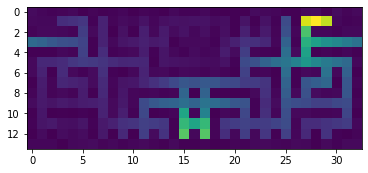

In [189]:
plt.imshow(value_fn.value_grid + 2*np.random.random(value_fn.value_grid.shape))

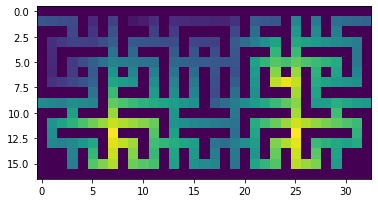

In [29]:
plt.imshow(value_fn.value_grid)

In [95]:
foo = [(1,0),(-1,0),(0,1),(0,-1)]

In [97]:
foo.pop(foo.index((0,1)))

(0, 1)

In [146]:
sum(np.var([(1,2),(1,3),(1,2),(1,3),(1,2),(1,3),(1,2),(1,3),(1,2)], axis=0))

0.24691358024691354

In [164]:
value_fn.value_grid + np.random.random(value_fn.value_grid.shape)

array([[4.86274247e-01, 7.22083021e-01, 9.39475735e-01, 7.72741290e-01,
        3.75023371e-01, 4.15317452e-01, 3.87466789e-02, 8.89286419e-01,
        9.25134322e-01, 9.40347713e-01, 3.89407153e-01, 3.27474912e-01,
        7.57066414e-01, 9.66476822e-01, 6.56446718e-01, 4.77709545e-01,
        5.16878908e-01, 1.85709977e-01, 8.23868418e-01, 3.35737082e-01,
        4.64760245e-02, 7.30596133e-01, 4.20478010e-01, 9.40175707e-01,
        3.89219567e-01, 9.72387190e-01, 7.65386896e-01, 8.49933122e-01,
        3.50411050e-01, 1.86109826e-01, 2.59098720e-01],
       [8.45346547e-01, 5.67704255e-01, 2.32885560e-01, 2.50457977e+01,
        5.03831423e-01, 5.69598714e+01, 6.35719232e+01, 6.92433526e+01,
        8.18721843e-01, 5.37786085e+01, 9.68363111e-01, 4.91611285e+01,
        1.53540004e-01, 4.39370359e+01, 4.23394655e+01, 4.01894447e+01,
        3.75524924e+01, 3.57633370e+01, 7.48883213e-01, 3.34636348e+01,
        9.08714695e-01, 4.66793590e+01, 4.31949140e-01, 7.57404906e+01,
       

In [155]:
(1,2)-(4,5)

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [151]:
f"MOVE {4} {5} {6} {sum(np.var([],axis=0))}"

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: 'numpy.float64' object is not iterable

# Playing with Naïve bayes

In [587]:
from textblob.classifiers import NaiveBayesClassifier

In [588]:
train = [
    ("it's a lovely day", "happy"),
    ("this meal is delicious", "happy"),
    ("i like cycling", "happy"),
    ("the food is burnt", "sad"),
    ("time goes too quickly", "sad"),
    ("carolina is far away", "sad"),
    ("Trump is an asshole", "angry"),
    ("I can't find my t-shirt!", "angry"),
    ("They stole my bycicle", "angry"),
]
cl = NaiveBayesClassifier(train)

In [589]:
cl.classify("my grandmother died")

'angry'

# Auto-Mark: the automatic marker
## The dataset

In [319]:
import pdfminer.high_level as high_level
import re
import gensim
import gensim.downloader as api
# wv = api.load('word2vec-google-news-300')
from transformers import BertModel, BertForMaskedLM, BertConfig,BertTokenizer, PreTrainedEncoderDecoder
from os import listdir
from os.path import isfile, join
import tqdm.notebook as tqdm 
from src.dataset_loaders import RawDataLoader
from src.DataProcessors import DataProcessor
import csv

In [260]:
import torch
import numpy
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import Module
from torch.nn.modules.activation import MultiheadAttention

In [258]:
pdf_base_path = "./datasets/TAD_Marking/"
file_names = [f for f in listdir(mypath) if isfile(join(mypath, f)) and ".pdf" in f]

In [253]:
multi_PDF_data = []
for name in tqdm.tqdm(file_names):
    pdf_text = high_level.extract_text(join(pdf_base_path, name))
    multi_PDF_data.append(pdf_text)

In [255]:
pdf_paragraphs = pdf_text.split("\n\n")
pdf_paragraphs = [x for x in pdf_paragraphs if len(x.split(" ")) > 10 or re.match(r"Q[1-5]", x, re.IGNORECASE)]
len(pdf_paragraphs)

17

In [256]:
for pdf_text in multi_PDF_data:
    pdf_paragraphs = pdf_text.split("\n\n")
    pdf_paragraphs = [x for x in pdf_paragraphs if len(x.split(" ")) > 10 or re.match(r"Q[1-5]", x, re.IGNORECASE)]
    print(len(pdf_paragraphs), end=", ")

27, 51, 70, 29, 7, 114, 18, 35, 96, 28, 68, 22, 30, 39, 50, 65, 28, 61, 52, 29, 26, 150, 23, 105, 64, 148, 28, 55, 43, 32, 8, 48, 33, 28, 7, 20, 35, 16, 22, 25, 89, 10, 47, 71, 26, 75, 23, 45, 35, 17, 

In [274]:
with open('datasets/TAD_Marking/marks.tsv') as tsvfile:
    reader = csv.DictReader(tsvfile, dialect='excel-tab')
    results = {}
    for l in reader:
        results[l["GUID"]] = list(l.values())

In [496]:
class TAD_PDF_RawDataLoader(RawDataLoader):
    def __init__(self, data_directory="./datasets/TAD_Marking/"):
        file_names = [f for f in listdir(data_directory) if isfile(join(data_directory, f)) and ".pdf" in f]
        multi_PDF_data = []
        for name in tqdm.tqdm(file_names):
            pdf_text = high_level.extract_text(join(pdf_base_path, name))
            multi_PDF_data.append(pdf_text)
            
        self.max_scores = [7,4,5,5,11,3]
            
        with open('datasets/TAD_Marking/marks.tsv') as tsvfile:
            reader = csv.DictReader(tsvfile, dialect='excel-tab')
            self.results = {}
            for l in reader:
                self.results[l["GUID"]] = list(l.values())
        
        valid_index = int(len(multi_PDF_data)*0.8)
        test_index = int(len(multi_PDF_data)*0.9)
        self.train_split = multi_PDF_data[:valid_index]
        self.valid_split = multi_PDF_data[valid_index:test_index]
        self.test_split = multi_PDF_data[test_index:]
        
    
    def _get_split(self, split):
        if split=="train":
            return self.train_split
        elif split=="valid":
            return self.valid_split
        elif split=="test":
            return self.test_split
        elif split=="all":
            return self.train_split + self.valid_split + self.test_split
        else:
            raise Exception(f"'{split}' split not recognised.")
    
    def paragraphs_for_multi_regression(self, split, size=sys.maxsize, full_docstring=False):
        """
        This method returns a standard format of [(source_str, target_str)] used for translation.
        
        split: str: "train", "valid", "test", "all"
        """
        data_split = self._get_split(split)
        separated_paragraphs = []
        for pdf_text in data_split:
            word_set = set(pdf_text.lower().replace("\n", " ").split(" "))
            GUID = None
            for key in self.results.keys():
                if key.lower() in word_set:
                    GUID = key
                    break
            if GUID == None:
                continue
            
            pdf_paragraphs = pdf_text.split("\n\n")
            pdf_paragraphs = [x for x in pdf_paragraphs if len(x.split(" ")) > 10 or re.match(r"Q[1-5]", x, re.IGNORECASE)]
            
            sample = {}
            sample["paragraphs"] = pdf_paragraphs
            normalized_scores = [float(s)/m for s, m in zip(self.results[GUID][1:7], self.max_scores)]
            sample["scores"] = normalized_scores
            separated_paragraphs.append(sample)
        return separated_paragraphs

In [497]:
raw_loader = TAD_PDF_RawDataLoader()

In [498]:
data = raw_loader.paragraphs_for_multi_regression("train")

In [547]:
[len(tok.encode(p)) for p in data[1]["paragraphs"]]

[254,
 74,
 68,
 50,
 292,
 133,
 58,
 23,
 52,
 30,
 16,
 31,
 75,
 47,
 444,
 50,
 95,
 17,
 48,
 131,
 123,
 42,
 30,
 34,
 57,
 35,
 39,
 103,
 143,
 16,
 41,
 297,
 21,
 29,
 85,
 18,
 20,
 53,
 82,
 62,
 22,
 72,
 61,
 153,
 58,
 56,
 58,
 153,
 9,
 111,
 22]

## Data transformation

In [500]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [564]:
class TAD_PDF_DataProcessor(DataProcessor):
    def __init__(self, task_data, max_paragraph_len=512, max_paragraphs=100):
        """
        Things like max sequence length should be passed here and enforced elsewhere.
        If the dataset is too large to fit, this is where the transformations will happen
        to save the samples in a database or use IDs to make transfer faster.
        """
        self.task_data = task_data
        self.max_paragraph_len = max_paragraph_len
        self.max_paragraphs = max_paragraphs
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.PAD = self.tokenizer.pad_token_id
        
    def __len__(self):
        return len(self.task_data)
    
    def __getitem__(self, idx):
        sample = self.task_data[idx]
        paragraphs = sample["paragraphs"]
        scores = sample["scores"]
        sample = {'paragraphs': self.encode(paragraphs), 'scores': torch.tensor(scores)}
        return sample
    
    def encode(self, paragraphs):
        """
        This function needs to produce all the necessary outputs for a model 
        to only take this as input and produce a correct output.
        """
        return pad_sequence([torch.Tensor(self.encode_paragraph(paragraph)).type(torch.LongTensor) for paragraph in paragraphs[:self.max_paragraphs]], padding_value=self.PAD).T
    
    def encode_paragraph(self, paragraph):
        return self.tokenizer.encode(paragraph)[:self.max_paragraph_len]
    
    def collate(self, input_samples):
        collated_samples = {}
        max_pra_dims = tuple(torch.max(torch.tensor([sample["paragraphs"].shape for sample in input_samples]), axis=0)[0])
        batch = []
        for sample in input_samples: 
            num_paras, para_length = sample["paragraphs"].shape
            padded = torch.zeros(max_pra_dims)
            padded[:num_paras, :para_length] = sample["paragraphs"]
            batch.append(padded)
            
        collated_samples["multi_paras"] = torch.stack(batch)
        collated_samples["multi_scores"] = torch.stack([sample["scores"] for sample in input_samples])
        return collated_samples
    
    def decode(self, output_tensor):
        """
        This funciton should produce a correct output for the specified task, 
        it doesn't need to be the same for every transformation or task.
        """
        pass
    
    def to_dataloader(self, batch_size, repeat=False, num_workers=4, shuffle=True):
        return DataLoader(self, batch_size=batch_size, num_workers=num_workers,\
                           drop_last=False, collate_fn = self.collate, shuffle=shuffle)
    
    def save(self, path):
        """
        This should save the entire object for easy access. Saving and Loading is
        specific to the dataProcessors.
        """
        pass
        
    def load(path):
        """
        STATIC METHOD
        will load all kinds of data processors using torch.
        """
        return torch.load(path)

In [565]:
processor = TAD_PDF_DataProcessor(data)

In [566]:
processor.__getitem__(1)["paragraphs"].shape

torch.Size([51, 444])

In [567]:
s1 = processor.__getitem__(1)
# s2 = processor.__getitem__(1)
# samples = [s1,s2]
# processor.collate(samples)

In [423]:
s1 = processor.encode(["foo", "bar baz", "lor em", "lor em"])
s2 = processor.encode(["foo", "bar baz", "lor em sum"])
samples = [s1,s2]
print(s1.shape, s2.shape)
max_pra_len = tuple(torch.max(torch.tensor([paras.shape for paras in samples]), axis=0)[0])
num_paras, para_length = s2.shape
padded = torch.zeros(max_pra_len)
padded[:num_paras, :para_length] = s2
print(padded, padded.shape)
pad_sequence([sample[key] for sample in input_samples], padding_value=self.PAD)

torch.Size([4, 5]) torch.Size([3, 6])
tensor([[  101., 29379.,   102.,     0.,     0.,     0.],
        [  101.,  3347.,  8670.,  2480.,   102.,     0.],
        [  101.,  8840.,  2099.,  7861.,  7680.,   102.],
        [    0.,     0.,     0.,     0.,     0.,     0.]]) torch.Size([4, 6])


NameError: name 'input_samples' is not defined

In [568]:
dataloader = processor.to_dataloader(32)

In [569]:
for i_batch, sample_batched in enumerate(dataloader):
    print(sample_batched["multi_paras"].shape)
#     print(BPE_processor.decode_tensor(sample_batched["tgt"]))
    break

Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors


torch.Size([28, 100, 512])


In [239]:
configuration = BertConfig()
model = BertModel(configuration).from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_ids = torch.tensor(tokenizer.encode("raise an exception", add_special_tokens=True)).unsqueeze(0)  # Batch size 1

In [240]:
outputs = model(input_ids)

In [331]:
torch.tensor(tokenizer.encode("foo bar"))

tensor([  101, 29379,  3347,   102])

In [571]:
model = gensim.models.KeyedVectors.load_word2vec_format('path/to/file')

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/file'

In [ ]:
def from_pretrained(embeddings, freeze=True):
    assert embeddings.dim() == 2, \
         'Embeddings parameter is expected to be 2-dimensional'
    rows, cols = embeddings.shape
    embedding = torch.nn.Embedding(num_embeddings=rows, embedding_dim=cols)
    embedding.weight = torch.nn.Parameter(embeddings)
    embedding.weight.requires_grad = not freeze
    return embedding

In [ ]:
class AutoMarkModel(Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model)

        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.norm3 = LayerNorm(d_model)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)
        self.dropout3 = Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        r"""Pass the inputs (and mask) through the decoder layer.

        Args:
            tgt: the sequence to the decoder layer (required).
            memory: the sequnce from the last layer of the encoder (required).
            tgt_mask: the mask for the tgt sequence (optional).
            memory_mask: the mask for the memory sequence (optional).
            tgt_key_padding_mask: the mask for the tgt keys per batch (optional).
            memory_key_padding_mask: the mask for the memory keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        tgt2 = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2, atts = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        if hasattr(self, "activation"):
            tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        else:  # for backward compatibility
            tgt2 = self.linear2(self.dropout(F.relu(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt, atts

# Gradients in PyTorch

In [45]:
import torch
lr=0.1

In [50]:
x = torch.tensor([5., 2.], requires_grad=True)
y = torch.tensor([-1., 1.], requires_grad=True)
loss = (-(x**2)*y).sum()

In [51]:
loss

tensor(21., grad_fn=<SumBackward0>)

In [52]:
(loss).backward()

In [53]:
x.grad

tensor([10., -4.])

# TranX: a semantic parser in Python

In [1]:
import sys
sys.path.insert(0, "src/external_repos/tranX")

In [2]:
from __future__ import print_function

import time

import astor
import six.moves.cPickle as pickle
from six.moves import input
from six.moves import xrange as range
from torch.autograd import Variable

import evaluation
from asdl.asdl import ASDLGrammar
from asdl.transition_system import TransitionSystem
from common.utils import update_args, init_arg_parser
from components.dataset import Dataset
from components.reranker import *
from components.standalone_parser import StandaloneParser
from model import nn_utils
from model.paraphrase import ParaphraseIdentificationModel
from model.parser import Parser
from model.reconstruction_model import Reconstructor
from model.utils import GloveHelper
from exp import *
%load_ext autoreload
%autoreload 2

In [35]:
arg_parser = init_arg_parser()
args = init_arg_parser().parse_args("--mode test \
                                     --load_model src/external_repos/tranX/data/pretrained_models/django.bin \
                                     --beam_size 15 \
                                     --test_file src/external_repos/tranX/data/django/test.bin \
                                     --save_decode_to 0.test.decode \
                                     --decode_max_time_step 100 \
                                     --example_preprocessor django_example_processor".split())

In [36]:
parser_cls = Registrable.by_name(args.parser)
parser = parser_cls.load(model_path=args.load_model, cuda=args.cuda)
parser.eval()

Parser(
  (src_embed): Embedding(718, 128)
  (production_embed): Embedding(83, 128)
  (primitive_embed): Embedding(541, 128)
  (field_embed): Embedding(65, 64)
  (type_embed): Embedding(17, 64)
  (encoder_lstm): LSTM(128, 128, bidirectional=True)
  (decoder_lstm): LSTMCell(704, 256)
  (src_pointer_net): PointerNet(
    (src_encoding_linear): Linear(in_features=256, out_features=256, bias=False)
  )
  (primitive_predictor): Linear(in_features=256, out_features=2, bias=True)
  (decoder_cell_init): Linear(in_features=256, out_features=256, bias=True)
  (att_src_linear): Linear(in_features=256, out_features=256, bias=False)
  (att_vec_linear): Linear(in_features=512, out_features=256, bias=False)
  (query_vec_to_action_embed): Linear(in_features=256, out_features=128, bias=False)
  (query_vec_to_primitive_embed): Linear(in_features=256, out_features=128, bias=False)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [29]:
interactive_mode(args)

Start interactive mode
load parser from [src/external_repos/tranX/data/pretrained_models/conala.bin]


KeyboardInterrupt: 

In [37]:
parser = StandaloneParser(args.parser,
                              args.load_model,
                              args.example_preprocessor,
                              beam_size=args.beam_size,
                              cuda=args.cuda)

def predict(desc):

    utterance = desc.strip()
    hypotheses = parser.parse(utterance, debug=True)

    pred_code_list = [hyp.code for hyp in hypotheses]
    return pred_code_list

load parser from [src/external_repos/tranX/data/pretrained_models/django.bin]


In [38]:
%%capture
code_list = predict('foo is an empty array')

In [39]:
code_list

['foo = []',
 "foo = ''",
 "foo = ('', '', '', '', '')",
 "foo = ('', '', '')",
 "foo = ('', '', [])",
 "foo = ('')",
 "foo = '' + foo",
 "signals = ''",
 'signals = []',
 'result = []',
 "result = ''",
 'foo = {}',
 'output = []',
 'help_text = []',
 'pass']

In [43]:
import numpy

In [47]:
numpy.array([])

array([], dtype=float64)

In [17]:
from src.tree_sitter_AST_utils import Tree_Sitter_ENFA, sub_str_from_coords, Node_Processor, \
                                        Code_Parser, StringTSNode, get_grammar_vocab, regex_to_member, \
                                        NodeBuilder, PartialNode, sub_str_from_coords, PartialTree
import json

In [18]:
with open("src/external_repos/tree-sitter-python/src/grammar.json", "r") as grammar_file:
            python_grammar = json.load(grammar_file)

In [19]:
python_parser = Code_Parser(python_grammar, "python", parser_library_path='src/external_repos/tree-sitter-python')

In [22]:
seq = ['module', 'import_from_statement', 'from', '<REDUCE>', 'dotted_name', 'identifier', 'threading', '<REDUCE>', '<REDUCE>', 'import', 
       '<REDUCE>', 'dotted_name', 'identifier', 'local', '<REDUCE>', '<REDUCE>', '<REDUCE>', '<REDUCE>']
tree = python_parser.sequence_to_partial_tree(seq)

Tree generation terminated


In [26]:
tree.to_string()

'from threading import local \n'

# Using RAY for parallel coomputation

In [23]:
import ray
ray.init(ignore_reinit_error=True)
%load_ext line_profiler

2020-08-08 11:23:42,298	ERROR worker.py:655 -- Calling ray.init() again after it has already been called.


In [106]:
class adder_Transform(object):
    def __init__(self):
        self.amount = [1,2]
    
    def __call__(self, samples):
        self_ref = ray.put(self)
        return ray.get([adder_Transform.process_sample.remote(self_ref, sample_obj) for sample_obj in samples])
            
    @ray.remote(num_cpus=0.5)
    def process_sample(self, sample):
        print(f"computing {sample} amount_ref {self}")
        time.sleep(1)
        sample["val"] = self.amount
        return sample

In [107]:
samples = [{'val':3},{'val':7},{'val':3},{'val':7},{'val':5},{'val':7},{'val':3}]*10
transform = adder_Transform()
transform(samples)

(pid=163) computing {'val': 5} amount_ref <__main__.adder_Transform object at 0x7f14b4465a90>
(pid=159) computing {'val': 7} amount_ref <__main__.adder_Transform object at 0x7f2ebcaf1780>
(pid=166) computing {'val': 3} amount_ref <__main__.adder_Transform object at 0x7f3374167b70>
(pid=160) computing {'val': 3} amount_ref <__main__.adder_Transform object at 0x7f5bbc63a470>
(pid=168) computing {'val': 7} amount_ref <__main__.adder_Transform object at 0x7f3f1c70d6d8>
(pid=354) computing {'val': 7} amount_ref <__main__.adder_Transform object at 0x7f772c136710>
(pid=367) computing {'val': 3} amount_ref <__main__.adder_Transform object at 0x7f5ac24dde80>
(pid=164) computing {'val': 3} amount_ref <__main__.adder_Transform object at 0x7f3a380e99b0>
(pid=162) computing {'val': 7} amount_ref <__main__.adder_Transform object at 0x7fb76803e390>
(pid=167) computing {'val': 3} amount_ref <__main__.adder_Transform object at 0x7f78901f0518>
(pid=381) computing {'val': 7} amount_ref <__main__.adder_Tr

2020-08-08 12:12:54,045	WARNING worker.py:1047 -- WARNING: 30 PYTHON workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.


(pid=401) computing {'val': 3} amount_ref <__main__.adder_Transform object at 0x7f7538271588>
(pid=381) computing {'val': 7} amount_ref <__main__.adder_Transform object at 0x7f13fc2547b8>
(pid=409) computing {'val': 3} amount_ref <__main__.adder_Transform object at 0x7fe8a07c0588>
(pid=408) computing {'val': 7} amount_ref <__main__.adder_Transform object at 0x7fd080533588>
(pid=459) computing {'val': 3} amount_ref <__main__.adder_Transform object at 0x7f038458b2b0>
(pid=418) computing {'val': 5} amount_ref <__main__.adder_Transform object at 0x7f9a58743518>
(pid=388) computing {'val': 7} amount_ref <__main__.adder_Transform object at 0x7efd1439f748>
(pid=159) computing {'val': 3} amount_ref <__main__.adder_Transform object at 0x7f2ebcaf1f98>
(pid=439) computing {'val': 3} amount_ref <__main__.adder_Transform object at 0x7f72e4209588>
(pid=430) computing {'val': 3} amount_ref <__main__.adder_Transform object at 0x7f1a3c782588>
(pid=504) computing {'val': 7} amount_ref <__main__.adder_Tr

KeyboardInterrupt: 

In [33]:
%lprun -u 1e-3 -f adder_Transform.__call__ transform(samples)

Timer unit: 0.001 s

Total time: 0.216318 s
File: <ipython-input-28-3efa78b1f144>
Function: __call__ at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                               def __call__(self, samples):
     6         1        216.3    216.3    100.0          return ray.get([self.process_sample.remote(self, sample_obj) for sample_obj in samples])

In [81]:
obj_ref = ray.put(1)

In [83]:
print(obj_ref)

ObjectID(ffffffffffffffffffffffff0100008011000000)
